In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from math import sqrt


import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,    
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

In [3]:
df = pd.read_csv('C:/Users/abdul/Desktop/DATA SCIENCE PROJECTS/Energy_Projects/Energy/energy_dataset.csv')

In [4]:
df = df.set_index('time')
df.index = df.index.str[:-6]
df.index=pd.to_datetime(df.index)

In [5]:
demand=pd.DataFrame({'demand': df['total load actual']})
demand

,demand
time,
2015-01-01 00:00:00,25385.0
2015-01-01 01:00:00,24382.0
2015-01-01 02:00:00,22734.0
2015-01-01 03:00:00,21286.0
2015-01-01 04:00:00,20264.0
...,...
2018-12-31 19:00:00,30653.0
2018-12-31 20:00:00,29735.0
2018-12-31 21:00:00,28071.0


In [6]:
# missing values
demand.isna().sum()

demand    36
dtype: int64

In [7]:
# handling missing values by dropping

demand=demand.dropna()
demand.isna().sum()

demand    0
dtype: int64

<Axes: >

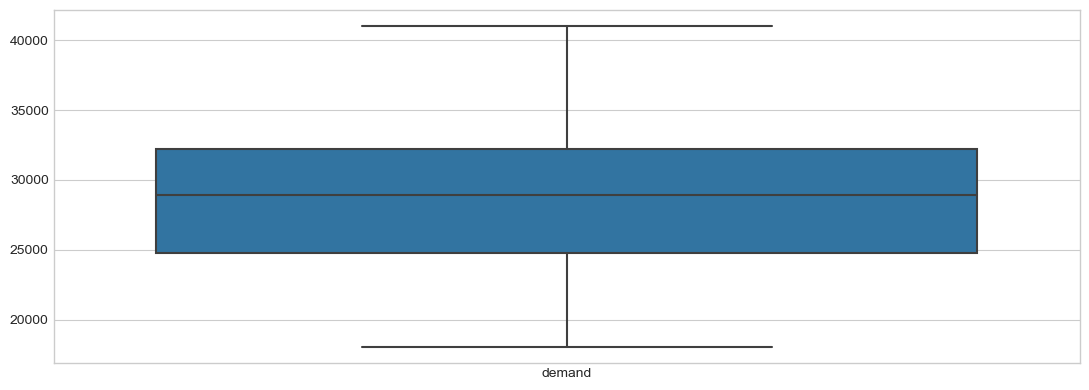

In [8]:
# checking for outliers
sns.boxplot(data=demand)

No outliers present

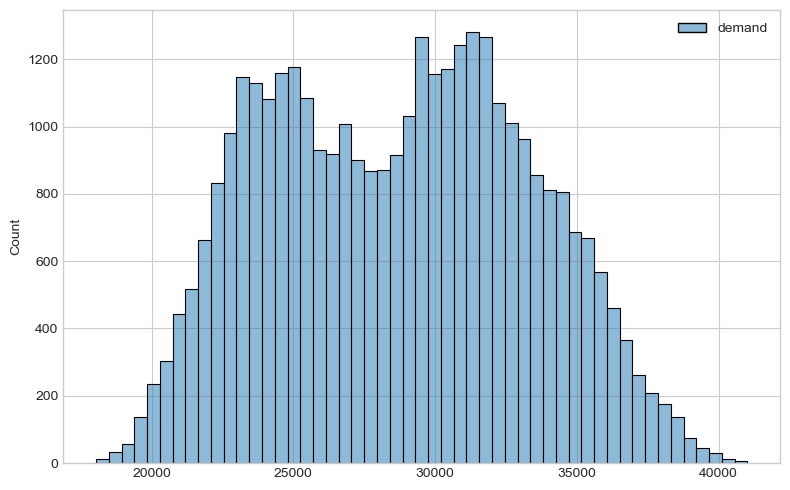

In [9]:
# checking data distribution
plt.figure(figsize=(8,5))
sns.histplot(demand);

Plot shows a bimodal distribution. This might be an indication of seasonal patterns

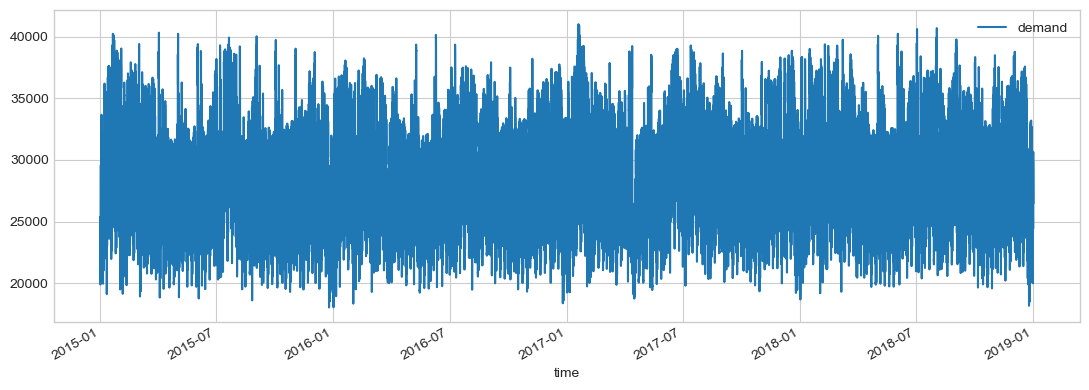

In [10]:
demand.plot();

In [11]:
# testing for stationarity using Augment Dickey-Fuller Test (ADF test)

result = adfuller(demand)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -21.469873
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Test statistics value is lesser than the critical value, therefore, null hypotethis is rejected i.e the data is stationary

## ARIMA MODEL

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

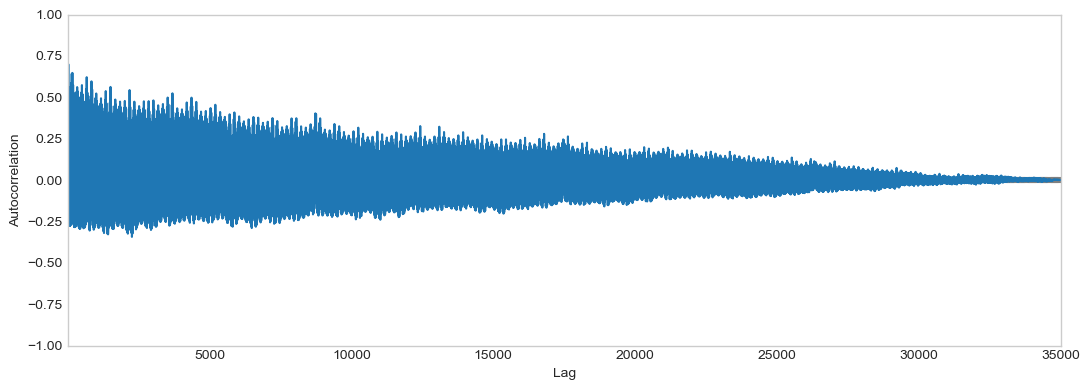

In [12]:
autocorrelation_plot(demand)

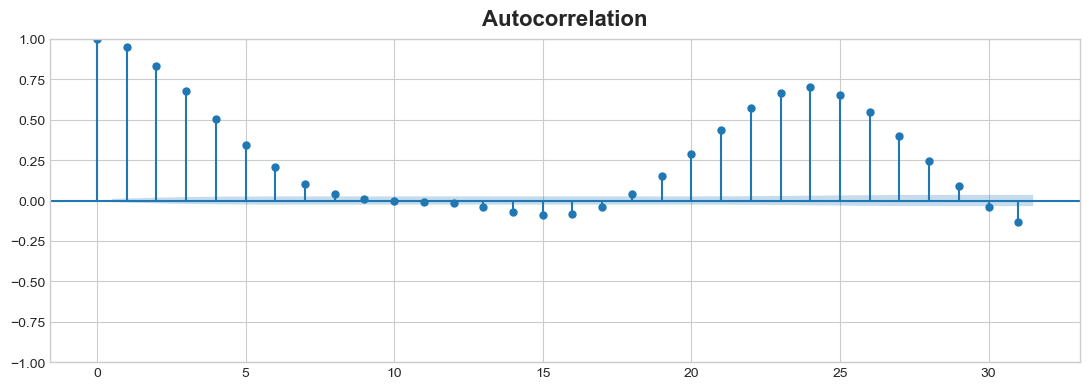

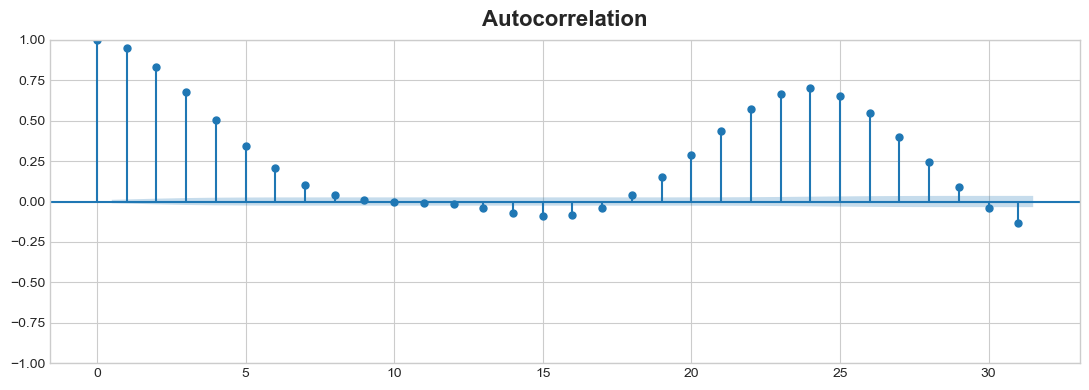

In [13]:
plot_acf(demand, lags=31)

There are positive correlation in the first seven lags (more significant for the first 5) which dimishes then becomes positive again from 19-29

Let's go with 5 lags first. Before training let's split the data 

In [14]:
# to predict one week ahead
horizon = 24*7

In [15]:
# demand_train, demand_test = train_test_split(
#     demand, test_size=365*24, shuffle=False)
# train=int(len(demand)*0.80)
# demand_train, demand_test =[]
demand_train, demand_test = demand[:-horizon], demand[-horizon:]

In [16]:
model = ARIMA(demand_train, order=(5,0,0))
model_fit = model.fit()
forecast = model_fit.predict(start=demand_train.shape[0], end=(demand_train.shape[0]+demand_test.shape[0])-1)


In [17]:
forecast

34860    22968.834522
34861    23290.888795
34862    24057.565510
34863    25037.004394
34864    26056.731119
             ...     
35023    28708.674268
35024    28708.674268
35025    28708.674268
35026    28708.674268
35027    28708.674268
Name: predicted_mean, Length: 168, dtype: float64

In [18]:
forecast.index=demand_test.index

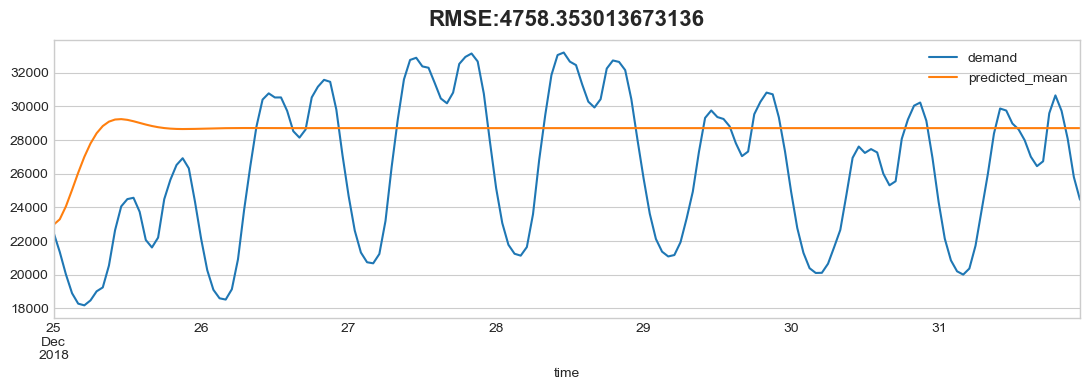

In [19]:
pd.concat([demand_test, forecast], axis=1).plot(title =f'RMSE:{sqrt(mse(demand_test,forecast))}');

In [20]:
# plt.figure(figsize=(10, 6))
# plt.plot(demand_train, label='Original Data')
# plt.plot(demand_test.index, forecast, label='Forecast', color='red')
# demand_test.plot(label='Future Value', color='green')

# # plt.fill_between(np.arange(n, n + n_steps), conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
# plt.title("ARIMA Forecast")
# plt.xlabel("Time")
# plt.ylabel("Value")
# plt.legend()
# plt.show()

In [21]:
# history=[x for x in demand_train.values]
# predictions=[]
# for t in range(len(demand_test.values)):
#     model = ARIMA(history, order=(5,0,0))
#     model_fit = model.fit()
#     output = model_fit.forecast()
#     yhat=output[0]
#     predictions.append(yhat)
#     obs = demand_test.iloc[t]
#     history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))
    
# # evaluate forecasts
# rmse = sqrt(mean_squared_error(demand_test, predictions))

# print('Test RMSE: %.3f' % rmse)
# plt.plot(demand_test, label='actual')
# plt.plot(predictions, color ='red',label='prediction')
    

## ML method

### XGBOOST

In [22]:
# create a copy of the original energy demand dataset
demand_ml = demand.copy()

In [23]:
# create timestep features
demand_ml['hour']=demand_ml.index.hour
demand_ml['day']=demand_ml.index.dayofyear
demand_ml['weeks']=demand_ml.index.week
demand_ml['months']=demand_ml.index.month

In [24]:
# split train and test data
X = demand_ml.drop('demand', axis=1)
y = demand_ml['demand']

X_train, X_test = X.iloc[:-horizon, :], X.iloc[-horizon:, :]
y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

### Without lag

In [25]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)


y_pred = xgb_model.predict(X_test)

In [26]:
predictions = pd.DataFrame({'Actual': y_test, 'Predictions': y_pred})

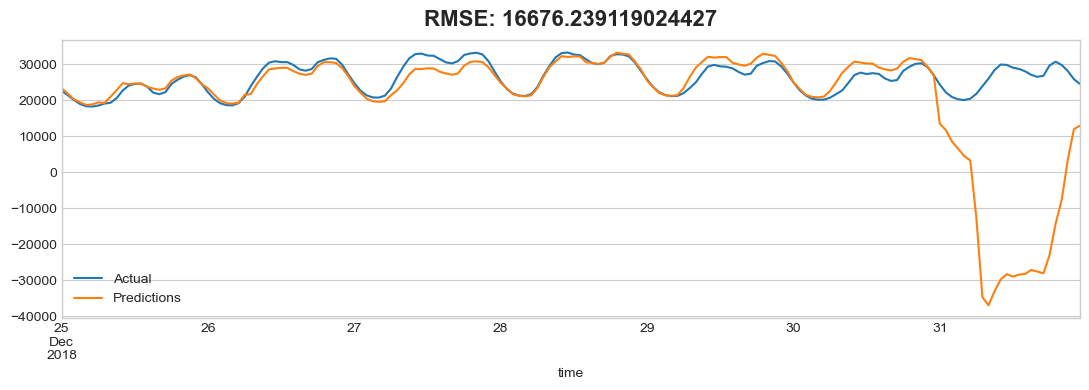

In [27]:
predictions.plot(title=f'RMSE: {sqrt(mse(y_test, y_pred))}')
plt.legend()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

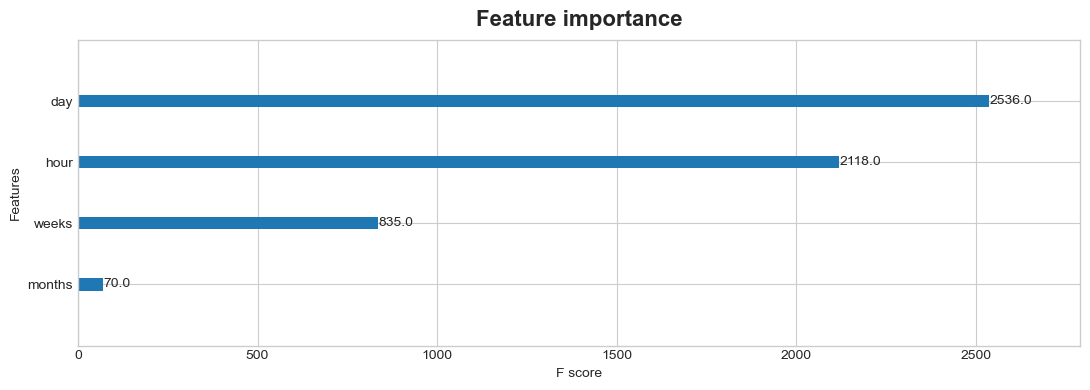

In [28]:
xgb.plot_importance(xgb_model)

## With Lag

In [29]:
lag_df = demand_ml.copy()

lag_df['prevweek'] = lag_df['hour'].shift(horizon)
lag_df['prev'] = lag_df.demand.shift(1)

lag_df.dropna(how='any', axis=0, inplace=True)

In [30]:
# split train and test data
X = lag_df.drop('demand', axis=1)
y = lag_df['demand']

X_train, X_test = X.iloc[:-horizon, :], X.iloc[-horizon:, :]
y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

In [31]:
lag_model = XGBRegressor()

lag_model.fit(X_train, y_train)

ylag_pred=lag_model.predict(X_test)

In [32]:
lag_predictions = pd.DataFrame({'Actual': y_test, 'Predictions': ylag_pred})

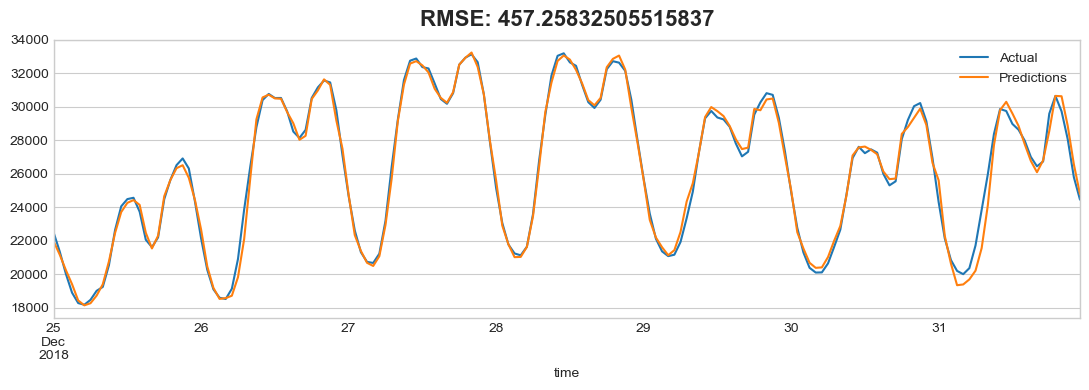

In [33]:
lag_predictions.plot(title=f'RMSE: {sqrt(mse(y_test, ylag_pred))}')
plt.legend()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

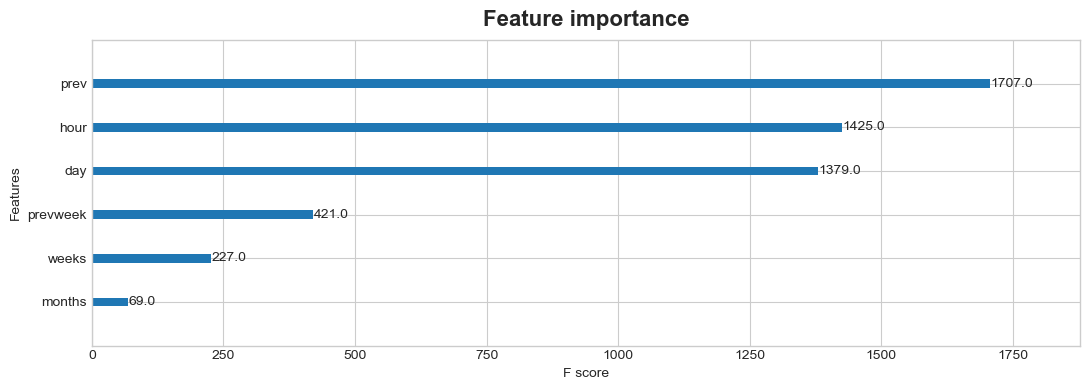

In [34]:
xgb.plot_importance(lag_model)

In [35]:
X_test.tail()

,hour,day,weeks,months,prevweek,prev
time,,,,,,
2018-12-31 19:00:00,19,365,1,12,19.0,29592.0
2018-12-31 20:00:00,20,365,1,12,20.0,30653.0
2018-12-31 21:00:00,21,365,1,12,21.0,29735.0
2018-12-31 22:00:00,22,365,1,12,22.0,28071.0
2018-12-31 23:00:00,23,365,1,12,23.0,25801.0


<Axes: xlabel='time'>

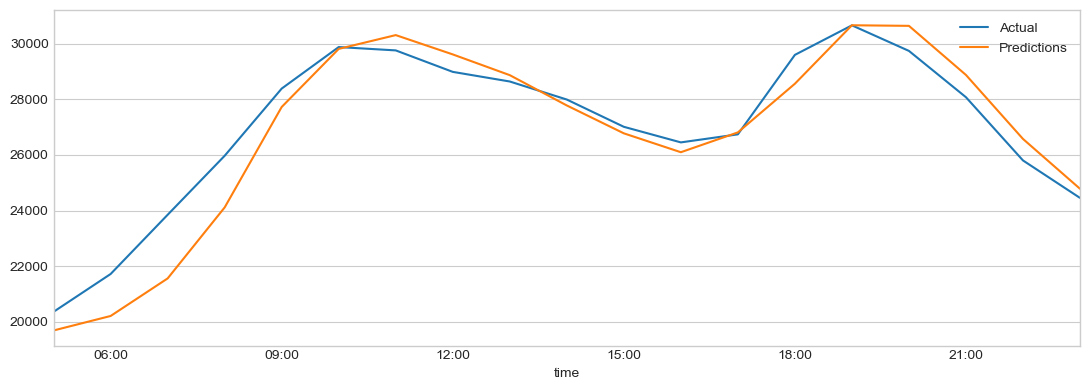

In [36]:
lag_predictions.loc['2018-12-31 5:00:00':].plot()

## Hyper parameter Tuning

In [37]:
xgbtuned = XGBRegressor()

In [ ]:
param_grid = {
            'learning_rate':[0.01,0.1,0.3],
            'n_estimators': [1000, 2000,3000]
}


grid_search = GridSearchCV(estimator = xgbtuned, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv=5)

grid_search.fit(X_train, y_train)

In [ ]:
# import sklearn

In [ ]:
sklearn.metrics.get_scorer_names()

In [ ]:
best_params = grid_search.best_params_
best_params

In [ ]:
best_model = grid_search.best_estimator_
y_pred=best_model.predict(X_test)

In [ ]:
fine_predictions = pd.DataFrame({'Actual': y_test, 'Predictions': y_pred})

In [ ]:
fine_predictions.plot(title=f'RMSE:{sqrt(mse(y_pred,y_test))}')

In [ ]:
xgb.plot_importance(best_model)

In [ ]:
best_model.fit(X_train, y_train)
y_pred=best_model.predict(X_test)
fine_predictions = pd.DataFrame({'Actual': y_test, 'Predictions': y_pred})
fine_predictions.plot(title=f'RMSE:{sqrt(mse(y_pred,y_test))}')